## Introduction - Purpose: 

Grade level warning use case is a way to look at students who are doing at an average level and are hence not flagged by the teachers and predict any downward slide in their performances

This is done by using forecasting (Holt's method) to capture any trends in their performances over time and predict for future 3 tests. If the predictions show a slide, then these students are flagged

## Toggling the raw codes: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Importing Libraries and connecting to SQL:

In [6]:
import pyodbc 
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

In [3]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def open_connection(dbname,user,pwd,host_name,port ):
    conn = psycopg2.connect(database = dbname, user = user, password = pwd, host = host_name, port = port)
    print ("Connected successfully")
    return conn

In [11]:
def run_sql_code(sql_stmnt,conn) : 
    cursor = conn.cursor()
    cursor.execute( sql_stmnt )
    
    if cursor.pgresult_ptr is not None:
        sql_table = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]
        sql_table_df =  pd.DataFrame(sql_table,columns = (column_names))
    else:
        sql_table_df =  "No table rows selected"

    return(sql_table_df)

### Connecting to  SQL server 
Enter password to connect to the Samarth Staging server : 

In [9]:
dbname ="postgres"
user = "postgres"
host_name = "143.110.183.73"
port = "15432"
pwd= getpass.getpass()

········


In [12]:
conn = open_connection(dbname,user,pwd,host_name,port )

Connected successfully


In [215]:
def print_class_metric( y_train, y_pred2 ) :
    conf_mat = confusion_matrix(y_train, y_pred2)
    FN = conf_mat[0,1]
    TN = conf_mat[0,0]
    FP =conf_mat[1,0]
    TP = conf_mat[1,1]
    Average_precision =  round((TP/(TP+FP) + TN/(TN + FN))/2, 4)
    Average_recall =  round((TP/(TP+FN) + TN/(TN + FP))/2, 4)
    
    # percentages for tp/fp/tn/fn
    perc_tp = "{:.2%}".format(round(TP/(TP+FP+TN+FN), 4))
    perc_fp = "{:.2%}".format(round(FP/(TP+FP+TN+FN), 4))
    perc_tn = "{:.2%}".format(round(TN/(TP+FP+TN+FN), 4))
    perc_fn = "{:.2%}".format(round(FN/(TP+FP+TN+FN), 4))
    
    #calculate F1 score
    F1_score = round(f1_score(y_train, y_pred2), 4)
    return Average_precision, Average_recall, F1_score, perc_tp, perc_fp, perc_tn, perc_fn

def print_conf_matrix(y_train, y_pred2, modelname):
    plt.rcParams["figure.figsize"] = (6.4, 4.8)
    conf_mat = confusion_matrix(y_train, y_pred2)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix - {}'.format(modelname)) 
    ax.xaxis.set_ticklabels(['Functional', 'Non-Functional']); ax.yaxis.set_ticklabels(['Functional', 'Non-Functional'])
    print('\n')

## Use Case - Grade-Level Warning : 

Grade level warning use case is a way to look at students who are doing at an average level and are hence not flagged by the teachers and predict any downward slide in their performances

This is done by using forecasting (Holt's method) to capture any trends in their performances over time and predict for future 3 tests. If the predictions show a slide, then these students are flagged

### Data considered - Whatsapp test results: 

We do not have class assessment data for more than 3 tests for the students and forecasting is unreliable with such a low number of  data points. 

Hence, we are considering whatsapp test results are for building the forecasting models. 
First, we can check if the whatsap results are a good proxy for the student assessment performance. 
We do this by looking at the correlation between the whatsapp marks and the student class assessment results 

In [15]:
sql_stmnt = ''' select student_id, Subject_desc, subm_grade_number,
sum(assessment_total_marks) as assessment_total_marks,
sum(assessment_marks) as assessment_marks 
FROM

    (select 
    base.student_id, subject.name as Subject_desc,grade.number as subm_grade_number ,
    component_type.name as component_name,
    
    avg(component.max_marks) as assessment_total_marks,
    avg(component_submission.assessment_marks) as  assessment_marks,
     --component_submission.assessment_marks*100.00/component.max_marks  as assessment_percent,
     grade.number
      from  student_submission_v2 base
    left join student_submission_v2_marks_submissions on base.id =  student_submission_v2_marks_submissions.studentsubmission_v2_id
    left join component_submission on student_submission_v2_marks_submissions.componentsubmission_id =  component_submission.id
    left join component on component_submission.component_id =  component.id
    left join component_type on component.component_type_id =  component_type.id
    left join grade on base.grade_id = grade.id 
    left join student on base.student_id  = student.id
    left join school on student.school_id = school.id
    left join assessment on base.assessment_id =  assessment.id   
    left join assessment_type on  assessment.type_v2_id  = assessment_type.id
    left join deadline on assessment.deadline_id =  deadline.id
    left join subject on base.subject_id =  subject.id 
    left join location  on school.location_id = location.id
    where student.is_enabled = 't'
    and school.is_active =  't'
    and school.udise > 1111111111 
    and location.district = 'SHIMLA'
    and grade.number in ('8')
    group by base.student_id, subject.name,grade.number  ,component_type.name) g
group by student_id, Subject_desc, subm_grade_number '''

In [21]:
df.to_csv('D:/Samagra/Samarth LR/New_data_Shimla_8.csv',index=False)

In [22]:
base_df =  pd.read_csv('D:/Samagra/Samarth LR/New_data_Shimla_8.csv')

In [28]:
Whatsapp_df = pd.read_csv('D:/Samagra/Samarth LR/Whatsapp_data_shimla.csv')

In [30]:
df3 = pd.merge(base_df, Whatsapp_df,  how='inner', left_on=['student_id','subject_desc'], right_on = ['studentid','subject'])

Checking correlation of the scores of the Whatsapp test vs the assessment results for Grade 8 of Shimla: 

In [150]:
print ( 'Correlation :  ', round( pearsonr(df3['assessment_percent'],df3['score'])[0],2))

Correlation :   0.32


Correlation is low for thes test results. This was done by taking average of the assessments test marks and checking it against the average of the whatsapp test marks for each subject for common students (around ~1200) 

### Building the Forecasting model: 

#### Looking at the dataset: 

Though the correlation value is low, we build out the forecasting model,  hoping to use the insights and logics later on a more reliable dataset

In [57]:
Whatsapp_ts_data = pd.read_csv('D:/Samagra/Samarth LR/Whatsapp_TS_data.csv')
Whatsapp_ts_data['score'] =  np.round(Whatsapp_ts_data['score'],0)
Whatsapp_ts_data_pivoted =  Whatsapp_ts_data.pivot_table(index=['studentid','grade_number','subject'], columns='week', values='score').reset_index()

Whatsapp data for a few weeks is pulled and pivoted. 
We only consider students who attempeted tests in all the weeks for now. 


A sample of the table created is shown below. Week 10-25 are considered because this subset is well populated 

In [63]:
Whatsapp_ts_data_pivoted

week,studentid,grade_number,subject,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,7240,2,Maths,75.0,87.0,87.0,75.0,100.0,87.0,75.0,100.0,100.0,100.0,75.0,100.0,100.0,81.0,100.0,100.0
1,43017,3,Maths,71.0,75.0,62.0,62.0,87.0,50.0,37.0,69.0,66.0,84.0,100.0,87.0,75.0,54.0,75.0,74.0
2,47591,2,Maths,85.0,100.0,70.0,61.0,65.0,87.0,56.0,87.0,62.0,62.0,62.0,100.0,94.0,50.0,56.0,81.0
3,58698,3,Maths,57.0,87.0,75.0,87.0,75.0,100.0,62.0,50.0,100.0,100.0,100.0,100.0,75.0,87.0,100.0,100.0
4,60659,2,Maths,100.0,100.0,60.0,100.0,71.0,87.0,62.0,100.0,94.0,68.0,100.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12551,1334190,1,Maths,87.0,62.0,87.0,75.0,87.0,50.0,87.0,87.0,87.0,100.0,87.0,87.0,50.0,100.0,81.0,87.0
12552,1334227,1,Maths,100.0,100.0,87.0,75.0,100.0,75.0,100.0,87.0,87.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
12553,1334775,1,Maths,100.0,75.0,100.0,50.0,100.0,75.0,100.0,62.0,100.0,100.0,87.0,100.0,100.0,75.0,75.0,100.0
12554,1336938,1,Maths,87.0,75.0,75.0,62.0,100.0,37.0,75.0,75.0,87.0,75.0,50.0,75.0,50.0,37.0,62.0,87.0


In [61]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [129]:
Results =  pd.DataFrame(Whatsapp_ts_data_pivoted[23].values,columns= ['Results_23'])

In [131]:
Results['Results_23'] = 0
Results['Results_24'] = 0
Results['Results_25'] = 0 

In [158]:
for i in range(0,Whatsapp_ts_data_pivoted.shape[0]):
    series1 = Whatsapp_ts_data_pivoted.iloc[i,list(range(3,16))].values
    fit1 = Holt(series1).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
    Results.loc[i,:] = fit1.forecast(3)

In [145]:
Results[Results > 100] =  100
Results[Results < 0] =  0

In [159]:
Results.to_csv("results_forecasting_whatsapp.csv", index= False)

### Data selection and results: 

Weeks 10- 22 are considered and Holt's method is used to forecast on the next 3 weeks results on this basis. 
The results show the classification results for predicting if any of the students are will fail the next tests:

In [154]:
Whatsapp_train_data =  Whatsapp_ts_data_pivoted.iloc[:,list(range(3,16))] 

In [171]:
Whatsapp_train_data['mean_score']=  Whatsapp_train_data.mean(axis=1)

In [186]:
Whatsapp_train_data['Above_45_flag'] = 0

In [187]:
Whatsapp_train_data.loc[Whatsapp_train_data['mean_score'] > 45,'Above_45_flag'] =  1 

In [172]:
Whatsapp_test_data =  Whatsapp_ts_data_pivoted.iloc[:,list(range(16,19))] 

In [174]:
Whatsapp_test_data['Below_45_last_3'] =  0 

In [177]:
Whatsapp_test_data.loc[Whatsapp_test_data[23]< 45, 'Below_45_last_3'] = 1
Whatsapp_test_data.loc[Whatsapp_test_data[24]< 45, 'Below_45_last_3'] = 1
Whatsapp_test_data.loc[Whatsapp_test_data[25]< 45, 'Below_45_last_3'] = 1

In [180]:
Results["Less_than_45_flag"] = 0
Results.loc[Results['Results_23'] < 45,'Less_than_45_flag' ] =  1
Results = Results.rename(columns ={'Less_than_45_flag':'Less_than-45_forecast'})
df1 = Whatsapp_train_data.join(Whatsapp_test_data)
train_data_summ =  df1[['mean_score','Above_45_flag','Below_45_last_3']]
results_data_summ = train_data_summ.join(Results)

In [202]:
results_data_summ = results_data_summ[['mean_score','Above_45_flag','Below_45_last_3','Less_than-45_forecast']]

In [206]:
results_data_above_45 = results_data_summ.loc[results_data_summ['Above_45_flag'] == 1,]


Avg. Precision:  0.5667 

Avg. Recall:  0.6456 

F1 Score:  0.2429 



Positive class is student failure (below 45 marks)


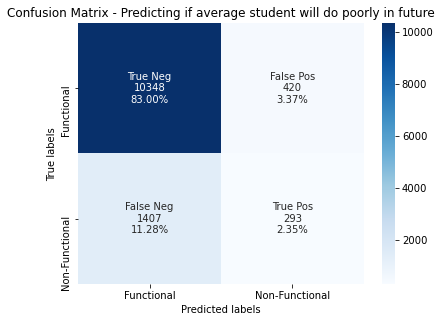

In [219]:
precision, recall, f1score, true_pos, false_pos, true_neg, false_neg = print_class_metric( results_data_above_45['Below_45_last_3'], results_data_above_45['Less_than-45_forecast'] )
print('\nAvg. Precision: ',precision,'\n')
print('Avg. Recall: ',recall,'\n')
print('F1 Score: ',f1score,'\n')
print_conf_matrix(results_data_above_45['Below_45_last_3'], results_data_above_45['Less_than-45_forecast'], 'Predicting if average student will do poorly in future')

print('Positive class is student failure (below 45 marks)')